# Loading data from Digital Earth Africa

This document provides an overview of loading data from the datacube in the context of Digital Earth Africa.

## Load packages
First we need to load some packages. The `datacube` package allows us to query and load from the datacube database. We must also include some code to allow us to import our utilities.

In [1]:
import datacube

# Allow importing of our utilities.
import sys
sys.path.append('../../Scripts')

## Connect to the datacube
We need to connect to the datacube database.
We will then be able to use the `dc` datacube object to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="04_Loading_data")

## Loading data using `load_ard()`

In general, datacube data is loaded using the [`dc.load()`](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html) function.

However, in DEAfrica we typically use the `load_ard()` function in the DEAfrica utilities to load data. It has several benefits over `dc.load()`, such as combining data from multiple, related products and automatically masking out missing or undesirable data. This function is preferred for loading Landsat products (`ls5_usgs_sr_scene`, `ls7_usgs_sr_scene`, `ls8_usgs_sr_scene`, `usgs_ls8c_level2_2`, `ga_ls8c_fractional_cover_2`) and Sentinel-2 products (`s2_l2a`).

For examples and more information on `load_ard()`, see [this notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Frequently_used_code/Using_load_ard.ipynb).

For examples and more information on `dc.load()`, see [this notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/03_Loading_data.ipynb).

The `load_ard()` function requires the following minimum arguments:

* `dc`: A `datacube.Datacube` instance used to query the datacube.
* `products`: A list of the products to load (to review DE Africa products, see the [Products and measurements](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/02_Products_and_measurements.ipynb) notebook).
* `x`: Defines the spatial region in the *x* dimension. By default, the *x* and *y* arguments accept queries in a geographical coordinate system WGS84, identified by the EPSG code *4326* - which uses latitude/longitude coordinates. If you would like to use a different coordinate system, specify its CRS with the `crs` argument.
* `y`: Defines the spatial region in the *y* dimension. The dimensions `longitude`/`latitude` and `x`/`y` can be used interchangeably for the CRS `EPSG:4326`.
* `time`: Defines the temporal extent. The time dimension can be specified using a tuple of datetime objects or strings in the "YYYY", "YYYY-MM" or "YYYY-MM-DD" format.

For the products we'll be loading data from, we must also specify the `output_crs` and `resolution`.

* `output_crs`: The coordinate reference system (CRS) of the output (the `xarray.Dataset` object and its data variables).
* `resolution` A 2-tuple of the `y` and `x` resolutions (in that order) in pixels per degree. The first value is typically negative. The value we use in this case (`(-0.00027, 0.00027)`) is a resolution of 30 meters per pixel, which is the native resolution of Landsat 5, 7, and 8.

There are also a few optional arguments specified:

* `min_gooddata`: Observations with less than this percent (as a fraction - so `1`==100%) of good quality pixels are discarded. 
Pixels containing clouds, cloud shadow, invalid data, or missing data do not count as good data.
* `group_by`: We specify `group_by='solar_day'` to combine multiple observations per day into one observation per day.

First, we need to import the `load_ard()` function.

In [3]:
from deafrica_datahandling import load_ard

Let's run a query to load Landsat 7 and 8 data for Dar es Salaam, Tanzania in 2018.
These are the products we'll load data from:

* Landsat 7: [ls7_usgs_sr_scene](https://explorer.digitalearth.africa/ls7_usgs_sr_scene)
* Landsat 8: [ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

It is often useful to re-use a set of query parameters to load data from multiple products.
To achieve this, we can load data using the "query dictionary" syntax.
This involves placing the query parameters inside a Python dictionary object which we can re-use for multiple data loads:

In [4]:
# Dar es Salaam, Tanzania - 2018
query = dict(dc=dc,
             min_gooddata=0.7,
             x=(39.20, 39.37),
             y=(-6.90, -6.70),
             time=("2018-01-01", "2018-12-31"),
             output_crs="EPSG:4326",
             resolution=(-0.00027, 0.00027),
             group_by='solar_day')

We can then use this query dictionary object as an input to `load_ard()`. 

> The `**` syntax below is Python's "keyword argument unpacking" operator.
This operator takes the named query parameters listed in the dictionary we created (e.g. `x=(39.20, 39.37)`), and "unpacks" them into the `load_ard()` function as new arguments. 
For more information about unpacking operators, refer to the [Python documentation](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists)

In [5]:
landsat_ds = load_ard(products=["ls7_usgs_sr_scene", "ls8_usgs_sr_scene"],
                      **query)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls7_usgs_sr_scene
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 4 out of 41 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


Let's run a query to load Sentinel-2 data for Dar es Salaam, Tanzania in 2018.

In [6]:
sentinel_2_ds = load_ard(products=["s2_l2a"],
                         **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 24 out of 71 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 24 time steps


The output of `load_ard()` for the Landsat data is `landsat_ds`, which is an `xarray.Dataset` object.

In [7]:
landsat_ds

<xarray.Dataset>
Dimensions:      (latitude: 742, longitude: 630, time: 4)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-31T07:31:54.636976 ... 2018-12-01T07:31:56.186494
    spatial_ref  int32 4326
  * longitude    (longitude) float64 39.2 39.2 39.2 39.2 ... 39.37 39.37 39.37
  * latitude     (latitude) float64 -6.7 -6.7 -6.7 -6.701 ... -6.899 -6.9 -6.9
Data variables:
    blue         (time, latitude, longitude) float32 nan nan nan ... 443.0 704.0
    green        (time, latitude, longitude) float32 nan nan nan ... 534.0 857.0
    red          (time, latitude, longitude) float32 nan nan nan ... 594.0 969.0
    nir          (time, latitude, longitude) float32 nan nan ... 1245.0 1967.0
    swir1        (time, latitude, longitude) float32 nan nan ... 1355.0 2326.0
    swir2        (time, latitude, longitude) float32 nan nan ... 991.0 1689.0
    radsat_qa    (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    pixel_qa     (time, latitude, longitude) uint16 328 328 328 ... 322 322 322
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Interpreting the resulting `xarray.Dataset`
The variables `landsat_ds` and `sentinel_2_ds` are `xarray.Dataset` objects containing all data that matched the query parameters (spatial, temporal, product, etc.) inputted into `load_ard()`.

*Dimensions* 

* Identifies the number of timesteps returned in the search (`time`) as well as the number of pixels in the x and y dimensions of the data query. In this case, using a CRS of EPSG:4326, the x and y dimensions are called `longitude` and `latitude`, respectively. However, for many coordinate systems, they will be called `x` and `y`.

*Coordinates* 

* `time` identifies the date attributed to each returned timestep.
* `longitude` and `latitude` are the coordinates for each pixel within the spatial bounds of your query.

*Data variables*

* These are the measurements available for the nominated product. 
For every date (`time`) returned by the query, the measured value at each pixel (`latitude`, `longitude`) is returned as an array for each measurement.
Each data variable is itself an `xarray.DataArray` object ([see below](#Inspecting-an-individual-xarray.DataArray)). So this data really has 4 dimensions - 2 for space (`latitude`, `longitude`), 1 for time (`time`), and 1 for the data variables (`red`, `green`, `blue`, ...).

*Attributes*

* `crs` identifies the coordinate reference system (CRS) of the loaded data. 

### Inspecting an individual `xarray.DataArray`
The `xarray.Dataset` objects we loaded above are collections of individual `xarray.DataArray` objects that hold the actual data for each data variable/measurement. 
For example, all measurements listed under _Data variables_ above (e.g. `blue`, `green`, `red`, `nir`, `swir1`, `swir2`) are `xarray.DataArray` objects.

We can inspect the data in these `xarray.DataArray` objects for an `xarray.Dataset` named `ds` using either of the following syntaxes:
```
ds["measurement_name"]
```
or:
```
ds.measurement_name
```

Being able to access data from individual data variables/measurements allows us to manipulate and analyse data from individual satellite bands or specific layers in a dataset. 
For example, we can access data from the near infra-red satellite band (i.e. `nir`):

In [8]:
landsat_ds.nir

<xarray.DataArray 'nir' (time: 4, latitude: 742, longitude: 630)>
array([[[  nan,   nan,   nan, ...,  148.,  170.,  219.],
        [  nan,   nan,   nan, ...,  141.,  167.,  224.],
        [  nan,   nan,   nan, ...,  145.,  174.,  232.],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[3376., 2545., 2431., ...,  223.,  207.,  219.],
        [2677., 2432., 2337., ...,  205.,  206.,  208.],
        [2525., 2405., 2720., ...,  201.,  205.,  210.],
        ...,
        [3119., 2948., 2614., ..., 3014., 3091., 3032.],
        [3436., 3416., 2806., ..., 2905., 2676., 3132.],
        [3022., 3487., 3183., ..., 2851., 2529., 3146.]],

       [[2656., 2235., 2235., ...,  238.,  238.,  238.],
        [2445., 2235., 2319., ...,  238.,  280.,  238.],
        [  nan,   nan,   nan, ...,  238.,  238.,  238.],
        ...,
        [2492., 2281., 2197., ..., 2446., 2488., 2320.],
        [2661., 2451., 2027., ..., 2403., 2446., 2362.],
        [2661., 2704., 2366., ..., 2403., 2362., 2320.]],

       [[  nan,   nan,   nan, ...,  153.,  153.,  150.],
        [  nan,   nan,   nan, ...,  124.,  140.,  143.],
        [  nan,   nan,   nan, ...,  143.,  148.,  147.],
        ...,
        [3699., 3109., 2804., ..., 2648., 2992., 3104.],
        [3294., 3304., 3058., ..., 1725., 2066., 2820.],
        [2829., 3267., 3399., ..., 1592., 1245., 1967.]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-31T07:31:54.636976 ... 2018-12-01T07:31:56.186494
    spatial_ref  int32 4326
  * longitude    (longitude) float64 39.2 39.2 39.2 39.2 ... 39.37 39.37 39.37
  * latitude     (latitude) float64 -6.7 -6.7 -6.7 -6.701 ... -6.899 -6.9 -6.9
Attributes:
    units:         reflectance
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Note that the object header informs us that it is an `xarray.DataArray` containing data for the `nir` satellite band. 

Like an `xarray.Dataset`, the array also includes information about the data's dimensions, coordinates and attributes.

> **Note**: For a more in-depth introduction to `xarray` data structures, refer to the [official xarray documentation](http://xarray.pydata.org/en/stable/data-structures.html)

## Showing RGB representations of the data

Below are RGB images of the Landsat and Sentinel-2 data near a particular time. The white pixels are locations of missing or unclean data. In the case of Landsat and Sentinel-2 data loaded with `load_ard()`, these areas are usually clouds or cloud shadow.

### Landsat

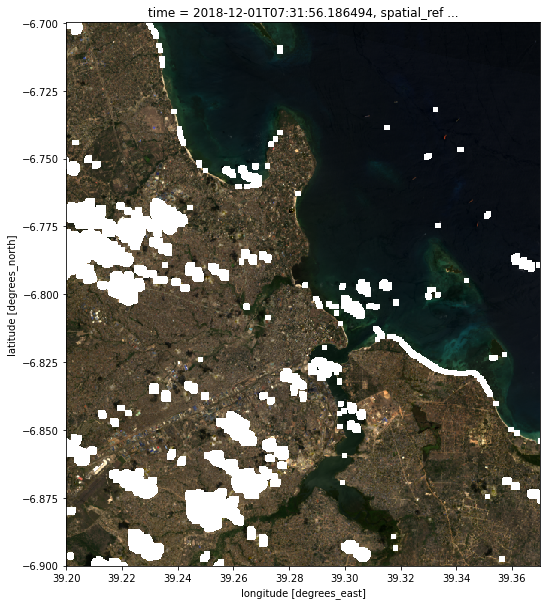

In [9]:
from deafrica_plotting import rgb

rgb(landsat_ds.sel(time="2018-12-01"), bands=['red', 'green', 'blue'], vmin=0, vmax=4000, size=10)

### Sentinel-2

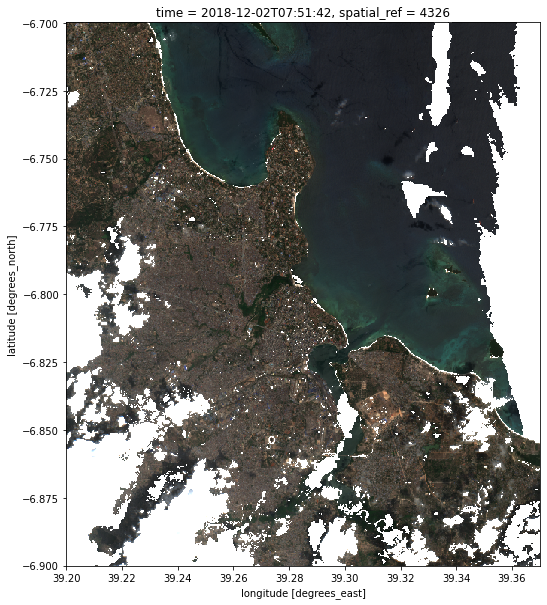

In [10]:
rgb(sentinel_2_ds.sel(time="2018-12-02"), bands=['B04', 'B03', 'B02'], vmin=0, vmax=5000, size=10)